In [313]:
# Taken base from: http://code.activestate.com/recipes/576930/
from collections import deque
from itertools import islice
import random
from math import log, ceil
import numpy as np
from bisect import insort
from random import randrange
import matplotlib.pyplot as plt

random.seed(2)
# Value, Next node on Skip list, Width of total nodes dependent on it
class Node(object):
    __slots__ = 'value', 'next', 'width'

    def __init__(self, value, next, width):
        self.value, self.next, self.width = value, next, width
        
    def __repr__(self):
        return 'Node({}, {})'.format(self.value, self.width) 


class End(object):
    'Sentinel object that always compares greater than another object'
    def __gt__(self, other):
        return 1

    def __ge__(self, other):
        return 1

    def __lt__(self, other):
        return 0

    def __le__(self, other):
        return 0
    
    def __repr__(self):
        return "END"

class Start(object):
    'Sentinel object that always compares greater than another object'
    def __gt__(self, other):
        return 0

    def __ge__(self, other):
        return 0

    def __lt__(self, other):
        return 1

    def __le__(self, other):
        return 1
    
    def __repr__(self):
        return "START"

EndNode = Node(End(), [], [])  # Singleton terminator node
class IndexableSkiplist:
    '''
    Sorted collection supporting O(log n) insertion, removal, and lookup by rank.
    
    Level 0 is ground
    '''
    def __init__(self, expected_size=100):
        self.size = 0
        self.maxlevels = int(1 + log(expected_size, 2))
        self.head = Node(Start(), [EndNode]*self.maxlevels, [1]*self.maxlevels)

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        node = self.head
        i += 1
        for level in reversed(range(self.maxlevels)):
            while node.width[level] <= i:
                i -= node.width[level]
                node = node.next[level]
        return node.value

    def insert(self, value):
        # Find first node on each level where node.next[levels].value > value
        chain = [None] * self.maxlevels # Previous Node at each level
        steps_at_level = [0] * self.maxlevels # Nodes traverse per level (Kind of jumps)
        node = self.head
        for level in reversed(range(self.maxlevels)):
            while value >= node.next[level].value:
                steps_at_level[level] += node.width[level]
                node = node.next[level]
            chain[level] = node

        # Insert a link to the newnode at each level
        d = min(self.maxlevels, 1 - int(log(random.random(), 2.0))) #Randomisation levels of this new node
        newnode = Node(value, [None]*d, [None]*d)
        steps = 0 # Counter to update width
        # Updating links and width
        # Going from ground level to top
        for level in range(d):
            prevnode = chain[level]
            newnode.next[level] = prevnode.next[level]
            prevnode.next[level] = newnode
            newnode.width[level] = prevnode.width[level] - steps
            prevnode.width[level] = steps + 1
            steps += steps_at_level[level] 
        # Adding node to all the superior levels
        for level in range(d, self.maxlevels):
            chain[level].width[level] += 1
        # Adding to the size
        self.size += 1

    def remove(self, value):
        # Find first node on each level where node.next[levels].value >= value
        chain = [None] * self.maxlevels # Previous node at each level
        node = self.head
        for level in reversed(range(self.maxlevels)):
            while node.next[level].value < value:
                node = node.next[level]
            chain[level] = node
        if value != chain[0].next[0].value:
            # Previous node in ground doesn't have the looking up value
            raise KeyError('Not Found')

        # Remove one link at each level
        d = len(chain[0].next[0].next)
        for level in range(d):
            prevnode = chain[level]
            prevnode.width[level] += prevnode.next[level].width[level] - 1
            prevnode.next[level] = prevnode.next[level].next[level]
        # Remove from top levels
        for level in range(d, self.maxlevels):
            chain[level].width[level] -= 1
        self.size -= 1

    def __iter__(self):
        'Iterate over values in sorted order'
        node = self.head.next[0]
        while node is not EndNode:
            yield node.value
            node = node.next[0]


class RunningMedian:
    'Fast running median with O(log n) updates where n is the window size'
    def __init__(self, n, iterable):
        self.it = iter(iterable)
        self.queue = deque(islice(self.it, n))
        self.skiplist = IndexableSkiplist(n)
        for elem in self.queue:
            self.skiplist.insert(elem)

    def __iter__(self):
        queue = self.queue
        skiplist = self.skiplist
        midpoint = len(queue) // 2
        
        yield skiplist[midpoint]
        for newelem in self.it:
            oldelem = queue.popleft()
            skiplist.remove(oldelem)
            queue.append(newelem)
            skiplist.insert(newelem)
            yield skiplist[midpoint]
            

class RunningPercentiles:
    'Fast running median with O(log n) updates where n is the window size'
    # TODO: Add stride
    def __init__(self, window, iterable, 
                 stride=1, percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
        self.it = iter(iterable)
        self.queue = deque(islice(self.it, window)) #Queue for timing order
        self.skiplist = IndexableSkiplist(window)
        self.percentiles = percentiles
        self.stride = stride
        for elem in self.queue:
            self.skiplist.insert(elem)

    def __iter__(self):
        queue = self.queue
        skiplist = self.skiplist
        percent_idx = [int(len(queue)*i) for i in self.percentiles]
        yield tuple(skiplist[p] for p in percent_idx)
        cont=0
        for newelem in self.it:
            oldelem = queue.popleft()
            skiplist.remove(oldelem)
            queue.append(newelem) 
            skiplist.insert(newelem)
            cont+=1
            if cont%self.stride==0:
                yield tuple(skiplist[p] for p in percent_idx)
                cont=0

In [322]:
data = [14, 8, 19, 7, 3, 13, 10, 11, 5, 12, 4, 14, 9, 4, 17, 13, 6, 7, 8, 3]
rp = RunningPercentiles(window=10, iterable=data, stride=3)
rp_iter = iter(rp)

In [323]:
next(rp_iter)

(5, 7, 11, 13, 19)

# Debug

In [324]:
M, N, window = 20, 20, 5
data = [randrange(M) for i in range(N)]

In [325]:
data = [14, 8, 19, 7, 3, 13, 10, 11, 5, 12, 4, 14, 9, 4, 17, 13, 6, 7, 8, 3]

In [326]:
it = iter(data)
queue = deque(islice(it, window))
skiplist = IndexableSkiplist(window)
print(queue)

deque([14, 8, 19, 7, 3])


In [327]:
for elem in queue:
    skiplist.insert(elem)
    print(skiplist.head)

Node(START, [1, 2, 2])
Node(START, [1, 3, 3])
Node(START, [1, 3, 4])
Node(START, [1, 4, 5])
Node(START, [1, 5, 6])


In [328]:
next_it = next(it)
print(next_it)
skiplist.insert(next_it)

13


# Traverse

In [329]:
skiplist.head

Node(START, [1, 6, 7])

In [330]:
skiplist.head.next

[Node(3, [1]), Node(19, [1, 1]), Node(END, [])]

In [331]:
skiplist.head.next[0].next

[Node(7, [1])]

In [332]:
skiplist.head.next[0].next[0].next

[Node(8, [1])]

In [333]:
skiplist.head.next[0].next[0].next[0].next

[Node(13, [1])]

In [334]:
skiplist.head.next[0].next[0].next[0].next[0].next

[Node(14, [1])]

In [335]:
skiplist.head.next[0].next[0].next[0].next[0].next[0].next

[Node(19, [1, 1])]

In [336]:
skiplist.head.next[0].next[0].next[0].next[0].next[0].next[0].next

[Node(END, []), Node(END, [])]

In [337]:
%%timeit
skiplist[4]

1.44 µs ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Quartiles

In [338]:
M, N, window = 1000, 1000000, 300000
data = [randrange(M) for i in range(N)]
running_quart = RunningPercentiles(window, data)

In [339]:
quart_iter = iter(running_quart)

In [340]:
%%timeit
next(quart_iter)

54.4 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [341]:
next(quart_iter)

(100, 251, 500, 749, 900)

## Example

In [342]:
import os
import pandas as pd

FILE_PATH = '/Users/camilovelasquez/Desktop/Documents/Datasets/Household_Power_Consumption/household_power_consumption.txt'



In [343]:
example_data = pd.read_csv(FILE_PATH, delimiter=';')
example_data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [345]:
example_data['datetime'] = pd.to_datetime(example_data['Date'] + ' ' + example_data['Time'])

In [346]:
numeric_cols = ['Global_active_power', 'Global_reactive_power','Voltage', 
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
                'Sub_metering_3']

for col in numeric_cols:
    example_data[col] = pd.to_numeric(example_data[col], errors='coerce')

In [347]:
example_data = example_data.sort_values('datetime')

In [348]:
subset = 100000

example_data = example_data.dropna()
example_data = example_data.iloc[:subset]

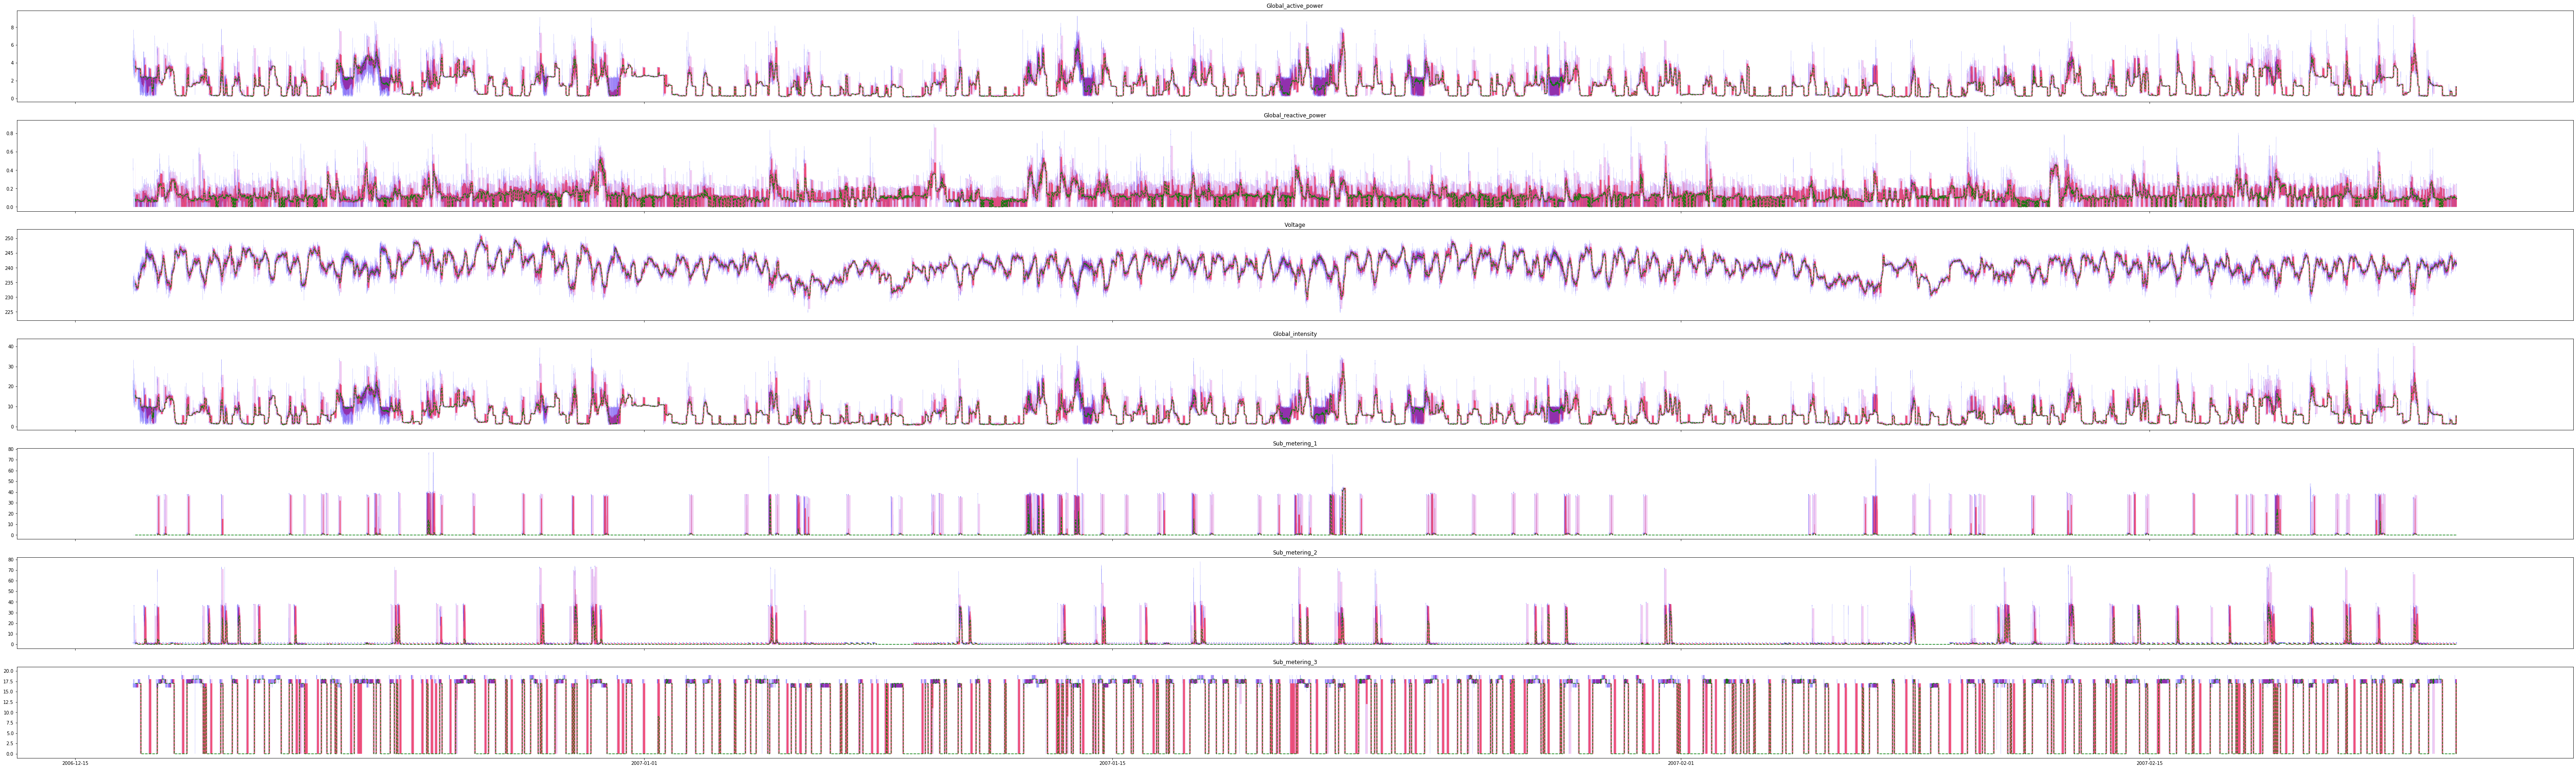

In [360]:
window = 100
fig, axes = plt.subplots(len(numeric_cols), 1, 
                         sharex=True, figsize=(100, 30))
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for idx, ax in enumerate(axes):
    column = numeric_cols[idx]
    ax.set_title(column)
    ax.plot(example_data.loc[:, 'datetime'], example_data.loc[:, column], 
            'b--', alpha=0.4, linewidth=0.3)
    running_quart = RunningPercentiles(window, example_data.loc[:, column])
    np_output = np.array(list(running_quart))
    for i in range(np_output.shape[1]):
        added_column =  column + '_p' + str(i+1)
        example_data.loc[window-1:,added_column] = np_output[:,i]
    ax.plot(example_data.loc[:, 'datetime'], 
            example_data.loc[:, column + '_p' + str(3)], 'g--', alpha=0.9)
    ax.fill_between(example_data.loc[:, 'datetime'], 
                    example_data.loc[:, column + '_p' + str(2)], 
                    example_data.loc[:, column + '_p' + str(4)], facecolor='red', alpha=0.6)
    ax.fill_between(example_data.loc[:, 'datetime'], 
                    example_data.loc[:, column + '_p' + str(1)], 
                    example_data.loc[:, column + '_p' + str(5)], facecolor='m', alpha=0.2)
                                                              

In [355]:
%%time
output = list(RunningPercentiles(window, example_data.loc[:, column]))

CPU times: user 2.27 s, sys: 11.7 ms, total: 2.28 s
Wall time: 2.29 s


In [356]:
np_out = np.array(output)
print(np_out.shape)
print(example_data.loc[:subset, 'Voltage'].shape)

(99901, 5)
(99971,)


In [357]:
example_data.loc[window-1:, 'Voltage_q1'] = np_out[:,0]

In [358]:
example_data

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,...,Sub_metering_2_p2,Sub_metering_2_p3,Sub_metering_2_p4,Sub_metering_2_p5,Sub_metering_3_p1,Sub_metering_3_p2,Sub_metering_3_p3,Sub_metering_3_p4,Sub_metering_3_p5,Voltage_q1
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100025,24/2/2007,04:29:00,0.292,0.116,241.76,1.2,0.0,1.0,0.0,2007-02-24 04:29:00,...,0.0,0.0,1.0,1.0,0.0,0.0,17.0,18.0,18.0,0.0
100026,24/2/2007,04:30:00,0.276,0.090,241.90,1.2,0.0,1.0,0.0,2007-02-24 04:30:00,...,0.0,0.0,1.0,1.0,0.0,0.0,17.0,18.0,18.0,0.0
100027,24/2/2007,04:31:00,0.222,0.000,243.53,1.0,0.0,0.0,0.0,2007-02-24 04:31:00,...,0.0,0.0,1.0,1.0,0.0,0.0,17.0,18.0,18.0,0.0
100028,24/2/2007,04:32:00,0.222,0.000,243.65,1.0,0.0,0.0,0.0,2007-02-24 04:32:00,...,0.0,0.0,1.0,1.0,0.0,0.0,17.0,18.0,18.0,0.0
